### Cats vs Dogs(With augmentation)
// Code by Om

In [1]:
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import kaggle


# Interactive widgets
from ipywidgets import widgets

In [2]:
# !kaggle competitions download -c dogs-vs-cats

In [3]:
# Import the data
base_dir = os.path.join(os.getcwd(), "Data/dogs-vs-cats-complete/train")

#### Data pre-processing

    1. Create tf.data.dataset
    2. Apply various data pipeline functions on the data

In [4]:
# Create tf.data.dataset
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir, 
                                                                                   label_mode='binary',
                                                                                   batch_size=128,
                                                                                   image_size=(120, 120),
                                                                                   subset='both',
                                                                                   validation_split=0.15, 
                                                                                   seed=42)

Found 25000 files belonging to 2 classes.
Using 21250 files for training.
Using 3750 files for validation.


2025-06-24 08:50:01.388773: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-24 08:50:01.388812: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-24 08:50:01.388816: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1750735201.389206 14996415 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750735201.389281 14996415 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
training_dataset.class_names

['cat', 'dog']

In [6]:
# train_dataset_final = training_dataset.shuffle(1000).cache().prefetch(tf.data.AUTOTUNE)
# validation_dataset_final = validation_dataset.shuffle(1000).cache().prefetch(tf.data.AUTOTUNE)

#### Augmentation model

In [7]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
])

#### Create and compile a CNN model with augmentation layers

In [8]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(120,120,3)),
    augmentation_layers,
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 59, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,273 (1.02 MB)

 Trainable params: 265,921 (1.01 MB)

 Non-trainable params: 352 (1.38 KB)

In [9]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, clipnorm=1.0), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

#### Train the CNN model

In [10]:
# EarlyStoppingCallback

MyCallback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

In [11]:
history = model.fit(training_dataset, 
                    epochs=35, 
                    validation_data=validation_dataset)

Epoch 1/35


2025-06-24 08:50:02.407998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.5380 - loss: 0.7808 - val_accuracy: 0.4955 - val_loss: 0.6936
Epoch 2/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.5989 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 0.6964
Epoch 3/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.6216 - loss: 0.6668 - val_accuracy: 0.5883 - val_loss: 0.6826
Epoch 4/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.6435 - loss: 0.6464 - val_accuracy: 0.6472 - val_loss: 0.6568
Epoch 5/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.6592 - loss: 0.6326 - val_accuracy: 0.6413 - val_loss: 0.7108
Epoch 6/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.6727 - loss: 0.6162 - val_accuracy: 0.6179 - val_loss: 0.8064
Epoch 7/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.6855 - loss: 0.5966 - val_accuracy: 0.6429 - val_loss: 0.8026
Epoch 8/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.6923 - loss: 0.5891 - val

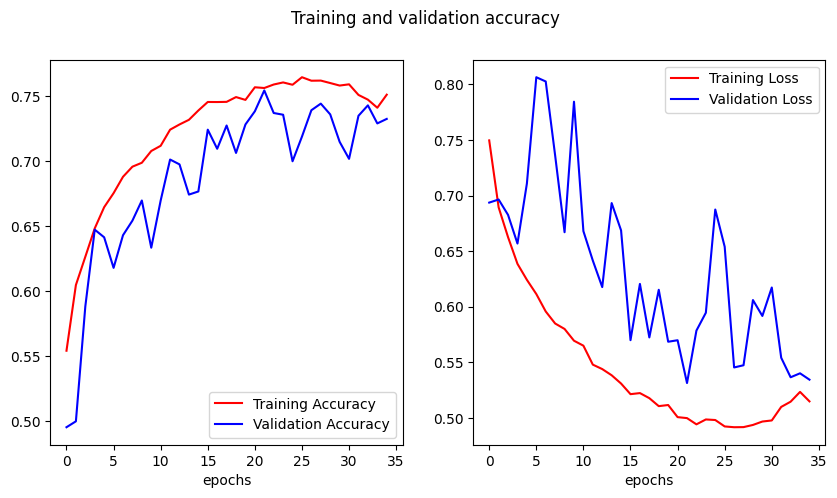

In [12]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()